In [4]:
from PIL import Image, ImageDraw, ImageSequence
import io
import matplotlib.pyplot as plt
import glob, os
import numpy as np
import contextlib

In [122]:
from utils import tb_save_image, onehot_to_rgb
import torch
import albumentations as A
import torchvision
import torchvision.transforms as transforms

from albumentations.pytorch import ToTensorV2
import numpy as np
from model import AttU_Net
from utils import get_loaders
import os
import matplotlib.pyplot as plt

MODELNAME = "Attention UNET"
LEARNING_RATE = 8e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 2
NUM_EPOCHS = 50
NUM_WORKERS = 2
IMAGE_HEIGHT = 256  # 1280 originally
IMAGE_WIDTH = 256  # 1918 originally
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR = "data/train_frames/"
TRAIN_MASK_DIR = "data/train_masks_proc/"
VAL_IMG_DIR = "data/val_frames/"
VAL_MASK_DIR = "data/val_masks_proc/"
TB_DIR = "logdir/log-attention-lr8e3"

train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0
            ),
            ToTensorV2(),
        ]
    )

val_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0
            ),
            ToTensorV2(),
        ]
    )

    #model = UNET(in_channels=3, out_channels=5).to(DEVICE)

from torch.utils.tensorboard import SummaryWriter


model = AttU_Net(img_ch=3, output_ch=5).to(DEVICE)
model.eval()

train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        BATCH_SIZE,
        train_transform,
        val_transform,
        NUM_WORKERS,
        PIN_MEMORY
    )


trans = A.Compose(
        [
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0
            ),
            ToTensorV2(),
        ]
    )


x, y = next(iter(val_loader))

model.eval()
x = x.to(device=DEVICE)
with torch.inference_mode():
    preds = model(x)
    preds = torch.argmax(preds, dim=1).float()
    preds = preds.unsqueeze(1)
    y = torch.argmax(y, dim=1).float().unsqueeze(1)
    # print(preds.shape)
    # preds = (preds > 0.5).float()
    all_preds = []
    all_masks = []
    for mask, pred in zip(torch.split(y, 1), torch.split(preds, 1)):
        mask = mask.squeeze()
        pred = pred.squeeze()

        mask = torch.Tensor(onehot_to_rgb(mask.cpu().numpy())).permute(2, 0, 1)
        pred = torch.Tensor(onehot_to_rgb(pred.cpu().numpy())).permute(2, 0, 1)
        
        mask = mask / 255.0
        pred = pred / 255.0
        
        all_masks.append(mask)
        all_preds.append(pred)
        
    preds = torch.stack(all_preds)
    y = torch.stack(all_masks)

print(f"x: {x.shape} - y: {y.shape} - pred: {preds.shape}")
x, y, preds = x[0,:,:,:].cpu(), y[0,:,:,:].cpu(), preds[0,:,:,:].cpu()

sum = torchvision.utils.make_grid([x, y, preds])

print(sum.shape)
writer = SummaryWriter("logdir/testrun")
writer.add_image('ex_img', sum, 0)


#predpath = os.path.join(folder, f"pred_{idx}.png")
#maskpath = os.path.join(folder, f"{idx}.png")
#torchvision.utils.save_image(
#    preds, predpath
#)
#torchvision.utils.save_image(y, maskpath)


#model.train()


"""

with torch.inference_mode():
    x = x[0,None,...]
    y = y[0,None,...]
    x = x.to(device=DEVICE)

    pred = model(x)
    pred = torch.argmax(pred, dim=1).float()
    pred = pred.squeeze()
    pred = torch.Tensor(onehot_to_rgb(pred.cpu().numpy())).permute(2, 0, 1)
    
    y = torch.argmax(y, dim=1).float().unsqueeze(1)
    mask = y.squeeze()
    mask = torch.Tensor(onehot_to_rgb(mask.cpu().numpy())).permute(2, 0, 1)
    print(mask.shape)

x = x.squeeze().cpu()
pred = pred.squeeze().cpu()
mask = mask.squeeze().cpu()         

# sum = np.concatenate((torch.squeeze(x).cpu(), torch.squeeze(preds).cpu(), torch.squeeze(y).cpu()), axis=1) # tf.squeeze deletes the batch dimension
sum = torchvision.utils.make_grid([x, pred, mask])

writer = SummaryWriter("logdir/testrun")
writer.add_image('ex_img', sum, global_step=10)
"""

x.shape, y.shape, pred.shape, sum.shape

x: torch.Size([2, 3, 256, 256]) - y: torch.Size([2, 3, 256, 256]) - pred: torch.Size([2, 3, 256, 256])
torch.Size([3, 260, 776])


(torch.Size([3, 256, 256]),
 torch.Size([3, 256, 256]),
 torch.Size([3, 256, 256]),
 torch.Size([3, 260, 776]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


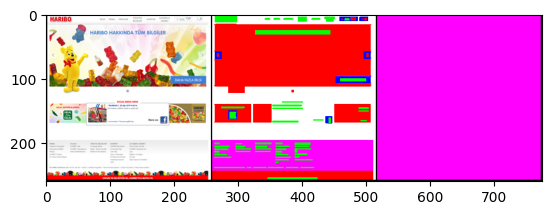

In [109]:
plt.imshow(sum.numpy().transpose(1,2,0))

In [112]:
x

tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.9922, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.9922, 1.0000, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.9922, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 0.9961,  ..., 1.0000, 1.0000, 1.

In [5]:
fp_in = "saved_images/epoch_*/pred_0.png"
fp_out = "pred_0.gif"

# use exit stack to automatically close opened images
with contextlib.ExitStack() as stack:

    # lazily load images
    imgs = (stack.enter_context(Image.open(f))
            for f in sorted(glob.glob(fp_in)))

    # extract  first image from iterator
    img = next(imgs)

    # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=500, loop=0)

In [6]:
def split_images(images, n=8):
    images = images[2:-2,:,:]
    image_list = []
    for i in range(n):
        starty = 2+(i)*258
        endy = starty+256
        image_list.append(images[:,starty:endy,:])
    
    return image_list


def all_split(image_paths):
    all_images = []
    for impath in image_paths:
        img = np.array(Image.open(impath).convert("RGB"))
        n = int((img.shape[1]-2)/258)
        all_images.extend(split_images(img, n=n))
    return all_images


def accuracy_for_p(y, yhat):
    comp = yhat == y
    acc = (comp[:,:,0] & comp[:,:,1] & comp[:,:,2]).mean()
    return acc

def generate_gif(images, filename):
    image_paths = sorted(glob.glob(images))
    imagelist = []
    for impath in image_paths:
        im = Image.open(impath)
        imagelist.append(im)
    
    imagelist[0].save(fp=filename, format="GIF", append_images=imagelist[1:], duration=500, loop=0, save_all=True)
    
    frames = []
    for frame, impath in zip(ImageSequence.Iterator(Image.open(filename)), image_paths):
        label = "Epoch " + impath.split(os.sep)[-2].split('_')[-1]
        d = ImageDraw.Draw(frame)
        d.text((10,100), label, fill=(0, 0, 0))
        del d
        b = io.BytesIO()
        frame.save(b, format="GIF")
        frame = Image.open(b)
        
        frames.append(frame)
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=500, loop=0)


def numpytogif(listofimages, filename):
    listofimages = [Image.fromarray(img, mode="RGB") for img in listofimages]
    listofimages[0].save(fp=filename, format="GIF", append_images=listofimages[1:], duration=500, loop=0, save_all=True)

generate_gif("saved_images/epoch_*/pred_0.png", "pred_0_all.gif")     

In [7]:
pred_images = sorted(glob.glob(os.path.join("saved_images", "epoch_40", "pred_*.png")))
gt_images = glob.glob(os.path.join("saved_images", "epoch_40", "*.png"))
gt_images = sorted(list(set(gt_images) - set(pred_images)))

preds = all_split(pred_images)
gts = all_split(gt_images)

In [8]:
numpytogif(all_split(sorted(glob.glob(os.path.join("saved_images", "epoch_*", "pred_0.png")))), "test.gif")

In [9]:
img1all = all_split(sorted(glob.glob(os.path.join("saved_images", "epoch_*", "pred_0.png"))))[::8]

In [10]:
len(img1all)

5

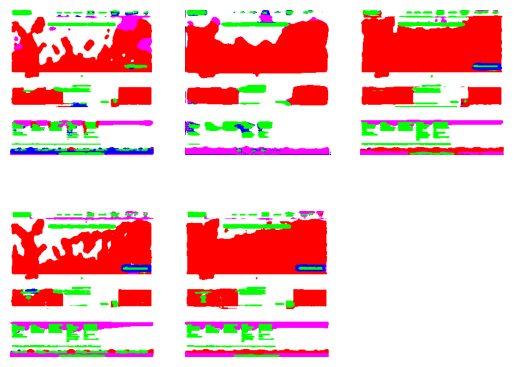

In [22]:
def plot_multiple(images): 
    from matplotlib import gridspec
    fig = plt.figure()
    grid = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)

    subfig00 = fig.add_subplot(grid[0, 0])
    subfig01 = fig.add_subplot(grid[0, 1])
    subfig02 = fig.add_subplot(grid[0, 2])
    subfig10 = fig.add_subplot(grid[1, 0])
    subfig11 = fig.add_subplot(grid[1, 1])
    #subfig12 = fig.add_subplot(grid[1, 2])
    
    subfigures = fig.get_axes()

    for i, subfig in enumerate(subfigures, start=1):
        subfig.spines['top'].set_visible(False)
        subfig.spines['right'].set_visible(False)
        subfig.axis('off')
        
    subfig00.imshow(images[0])
    subfig01.imshow(images[1])
    subfig02.imshow(images[2])
    subfig10.imshow(images[3])
    subfig11.imshow(images[4])
    #subfig12.imshow(images[5])
    
    plt.axis('off')
    plt.show()

plot_multiple(img1all)

In [45]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def split_each_image(gtpath, predpath, filename="animated_", folders=[1, 10, 20, 30, 40, 50]):
    # path will be os.path.join("saved_images", "epoch_*", "pred_n.png")
    all_pred_images = all_split(sorted(glob.glob(predpath)))
    all_gt_images = all_split(sorted(glob.glob(gtpath)))
    
    N = len(all_pred_images)
    num_images = N // len(folders)
    print(num_images)
    
    for i in range(0, num_images):
        temp_pred = all_pred_images[i::num_images]
        temp_gt = all_gt_images[i::num_images]
        # print(f"Len preds: {len(temp_pred)} - Len gtruths: {len(temp_gt)}")
        
        # assert len(temp_pred) != 6
        # assert len(temp_gt) != 6
        
        """
        from matplotlib import gridspec
        fig = plt.figure()
        grid = gridspec.GridSpec(ncols=6, nrows=2, figure=fig)
        
        for idx, (pred, gt) in enumerate(zip(temp_pred, temp_gt)):
            sf0 = fig.add_subplot(grid[0, idx])
            sf1 = fig.add_subplot(grid[1, idx])
            
            sf0.imshow(pred)
            sf1.imshow(gt)
        
        subfigures = fig.get_axes()

        for _, subfig in enumerate(subfigures, start=1):
            subfig.spines['top'].set_visible(False)
            subfig.spines['right'].set_visible(False)
            subfig.axis('off')
        
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        """
        
        imagelist = [get_concat_h(Image.fromarray(imgt), Image.fromarray(impr)) for imgt, impr in zip(temp_gt, temp_pred)]
        imagelist[0].save(fp=filename+f"{i}.gif", format="GIF", append_images=imagelist[1:], duration=500, loop=0, save_all=True)
        
        frames = []
        for epoch, frame in zip(folders, ImageSequence.Iterator(Image.open(filename+f"{i}.gif"))):
            label = f"Epoch {epoch}" # + impath.split(os.sep)[-2].split('_')[-1]
            d = ImageDraw.Draw(frame)
            d.text((10,100), label, fill=(0, 0, 0))
            del d
            b = io.BytesIO()
            frame.save(b, format="GIF")
            frame = Image.open(b)
            
            frames.append(frame)
        frames[0].save(filename+f"{i}.gif", save_all=True, append_images=frames[1:], duration=1000, loop=0)
        
 

for n in range(0, 12):
    split_each_image(
        os.path.join("saved_images", "epoch_*", f"pred_{n}.png"),
        os.path.join("saved_images", "epoch_*", f"{n}.png"),
        filename=f"{n}_animated_",
        folders = [1, 10, 20, 30, 40, 50]
        )

8
8
8
8
8
8
8
8
8
8
8
2
